In [1]:
import os
import requests
import shapely
import json

# !pip install pydotplus
from sklearn import tree
# from IPython.display import Image  
# import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pylab


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['linalg', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:]
    indices = np.argsort(importances)[::-1]
    #std = np.std([tree.feature_importances_ for tree in rf.estimators_],
    #         axis=0)

    pl.figure(figsize=(16,16))
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", #yerr=std[indices]
           align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
#featureImportancePlot(rf, X_foursquare.columns)

## Data Processing

This section combines the raw dataset with the typology and NYC shape file

In [3]:
twitter = pd.read_csv('Data/NYtwitter_output_12_17.csv')

In [4]:
NYCzip = gpd.read_file('shape7/region.shp')

In [5]:
typ = pd.read_excel('Data/NY final data for typologies 1.19.19.xlsx')

In [6]:
typ['Type_1.19'].replace('MHI - Advanced Exclusion', 'MHI - Ongoing Exclusion', inplace=True)

In [7]:
NYCzip['geojoin']=NYCzip['geoid'].astype(float)

In [8]:
#alldata = twitter.merge(typ, right_on="geoid", left_on="tract")

In [9]:
addlcensus = pd.read_stata('Data/UDP_NYC_Variables.dta')

In [10]:
addlcensus['geojoinaddl']=addlcensus['GEOid2'].astype(float)

In [11]:
alldata = typ.merge(addlcensus[['TOD', 'geojoinaddl']], right_on='geojoinaddl', left_on= 'geoid')

In [12]:
fulldataset = NYCzip.merge(alldata, right_on="geoid", left_on="geojoin")

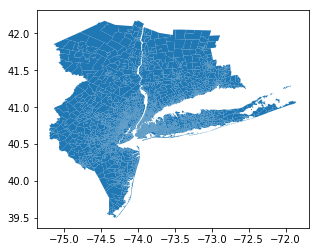

In [13]:
fulldataset.plot()

In [14]:
#creating twitter metrics
twitter["localpercentage"]=twitter.local_tweets/twitter.total_tweets
twitter["nbrpercentage"]=twitter.neighbor_tweets/twitter.total_tweets
twitter["visitorpercentage"]=twitter.other_tweets/twitter.total_tweets

In [15]:
fulldataset.shape

(5290, 125)

MHI - Stable or Early Stage of Exclusion              2004
MHI - Ongoing Exclusion                                762
LI - At Risk of Gentrification                         522
LI - Not Losing Low-Income Households                  482
LI - Ongoing Displacement of Low-Income Households     463
MHI - Advanced Gentrification                          370
VHI - Super Gentrification or Exclusion                314
LI - Ongoing Gentrification                            275
Missing Data                                            98
Name: Type_1.19, dtype: int64

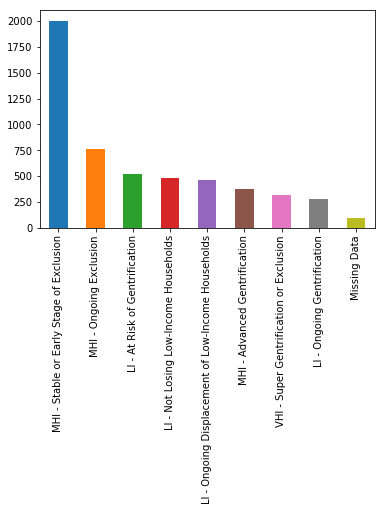

In [16]:
#checking merge results 
fulldataset['Type_1.19'].value_counts().plot(kind='bar')
fulldataset['Type_1.19'].value_counts()

In [17]:
#creating binary typology
fulldataset['Type_binary'] = fulldataset['Type_1.19'].copy()
fulldataset['Type_binary'].replace('VHI - Super Gentrification or Exclusion',0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
fulldataset['Type_binary'].replace('LI - At Risk of Gentrification',0,inplace=True)
fulldataset['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
fulldataset['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
fulldataset['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
fulldataset['Type_binary'].replace('Missing Data',0,inplace=True)
fulldataset['Type_binary'].replace(nan,0,inplace=True)

The percent of non-gentrifying is:0.878072


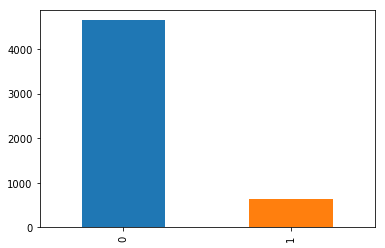

In [18]:
fulldataset['Type_binary'].value_counts().plot(kind='bar')
fulldataset['Type_binary'].value_counts()
print('The percent of non-gentrifying is:%f'%(fulldataset[fulldataset['Type_binary'] == 0]['geoid_x'].count()/fulldataset['geoid_x'].count()))

In [19]:
binaries = pd.read_csv('Data/NEW_6_BINARIES_DROPNAN.csv', index_col=0)

In [20]:
fulldataset.columns

Index(['aland_mi', 'objectid', 'statefp', 'countyfp', 'tractce', 'geoid_x',
       'name', 'namelsad', 'mtfcc', 'funcstat',
       ...
       'per_limove16', 'per_limove09', 'exclusion', 'popgrowth0016',
       'Incch0016', 'li_hh_16', 'Typology_final_1.19.19', 'TOD', 'geojoinaddl',
       'Type_binary'],
      dtype='object', length=126)

In [21]:
fulldataset.shape

(5290, 126)

In [22]:
fulldataset = fulldataset.merge(binaries, right_on= 'GEOID', left_on='geojoin')

In [23]:
binaries.columns

Index(['pct_ch_percol00_16_binary', 'pct_ch_hinc00_16_binary',
       'pct_ch_medhval00_16_binary', 'pct_ch_medrent00_16_binary',
       'Ongoing_adv_gent', 'gent00_16', 'gent90_00', 'Supergent16', 'GEOID'],
      dtype='object')

Some tracts drop off due to NULL values in critical fields for the development of the binary dependent variables (~450)

In [24]:
fulldataset.shape

(4829, 135)

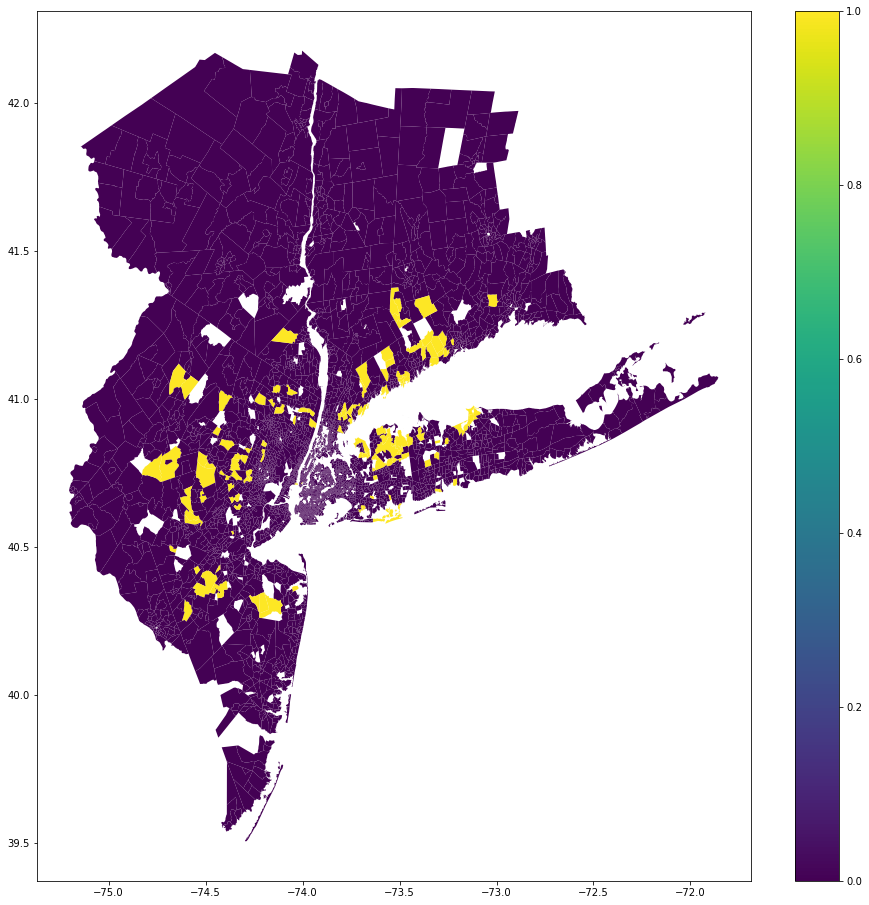

In [25]:
f, ax = plt.subplots(figsize=(16,16))
fulldataset.plot(column='Supergent16', ax=ax, legend=True)

# Modelling the Census Data as a baseline

We will use a subset of the features used to create the original typologies as a baseline

In [26]:
censussubset = fulldataset[['medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
  'Type_binary',
 'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [27]:
censussubset.shape

(4829, 14)

In [28]:
censussubset = censussubset.dropna()

In [29]:
censussubset.shape

(4829, 14)

In [30]:
censusmodeldata=censussubset.iloc[:, 0:-6]

In [91]:
cols = ['featureset', 'binaryvariable', 'modeltype', 'f1score']
resultsdf = pd.DataFrame(columns=cols, index=range(1))

In [96]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
resdict = []
print('[TN, FP][FN, TP]')
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    clf2 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf2.score(modeldata_train, modeltarget_train)
    testscore = clf2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget2, clf2.predict(modeldata2))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, clf2.predict(modeldata2)) )
    #featureImportancePlot(clf2, modeldata2.columns)
    resdict.append({'featureset': 'censusonly', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.871301775148 testscore:  0.890269151139 F1:  0.0 
 [[4235    0]
 [ 594    0]]
people_target trainscore:  0.971597633136 testscore:  0.965493443754 F1:  0.0759493670886 
 [[4677    9]
 [ 137    6]]
place1_target trainscore:  0.915976331361 testscore:  0.908902691511 F1:  0.452631578947 
 [[4241  167]
 [ 249  172]]
place2_target trainscore:  0.880177514793 testscore:  0.875776397516 F1:  0.811594202899 
 [[2984  321]
 [ 264 1260]]
gent16_target trainscore:  0.918047337278 testscore:  0.927536231884 F1:  0.0103626943005 
 [[4445    2]
 [ 380    2]]
supergent_target trainscore:  0.984023668639 testscore:  0.982056590752 F1:  0.735099337748 
 [[4638   57]
 [  23  111]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
resultsdf = resultsdf.append(resdict)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [106]:
resultsdf

,binaryvariable,f1score,featureset,fscore,modeltype
0,NaN,NaN,NaN,NaN,NaN
0,binary,NaN,censusonly,0.000000,DT
1,people_target,NaN,censusonly,0.075949,DT
2,place1_target,NaN,censusonly,0.452632,DT
3,place2_target,NaN,censusonly,0.811594,DT
4,gent16_target,NaN,censusonly,0.010363,DT
5,supergent_target,NaN,censusonly,0.735099,DT


### Modelling the Twitter data alone

In [35]:
all = fulldataset.merge(twitter, left_on="geojoin", right_on="tract")

In [37]:
binary_subset=all[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets'
           ]]

In [38]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']

In [39]:
targets1 = [all[['Type_binary']], all[['pct_ch_hinc00_16_binary']], all[['pct_ch_medhval00_16_binary']], all[['pct_ch_medrent00_16_binary']], all[['gent00_16_y']], all[['Supergent16']]]

[TN, FP][FN, TP]
binary trainscore:  0.871853546911 testscore:  0.863393810032 F1:  0.0192307692308 
 [[2710    4]
 [ 404    4]]


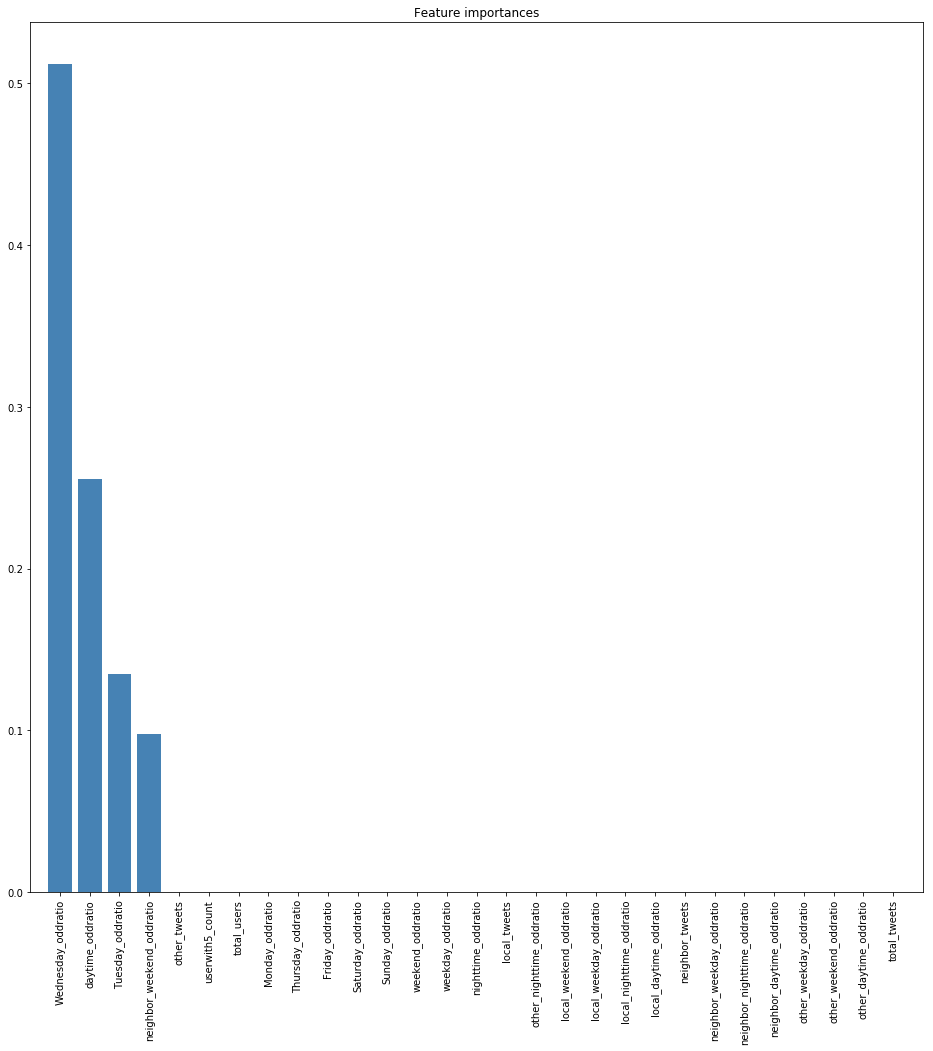

people_target trainscore:  0.957894736842 testscore:  0.957310565635 F1:  0.0704225352113 
 [[2985    3]
 [ 129    5]]


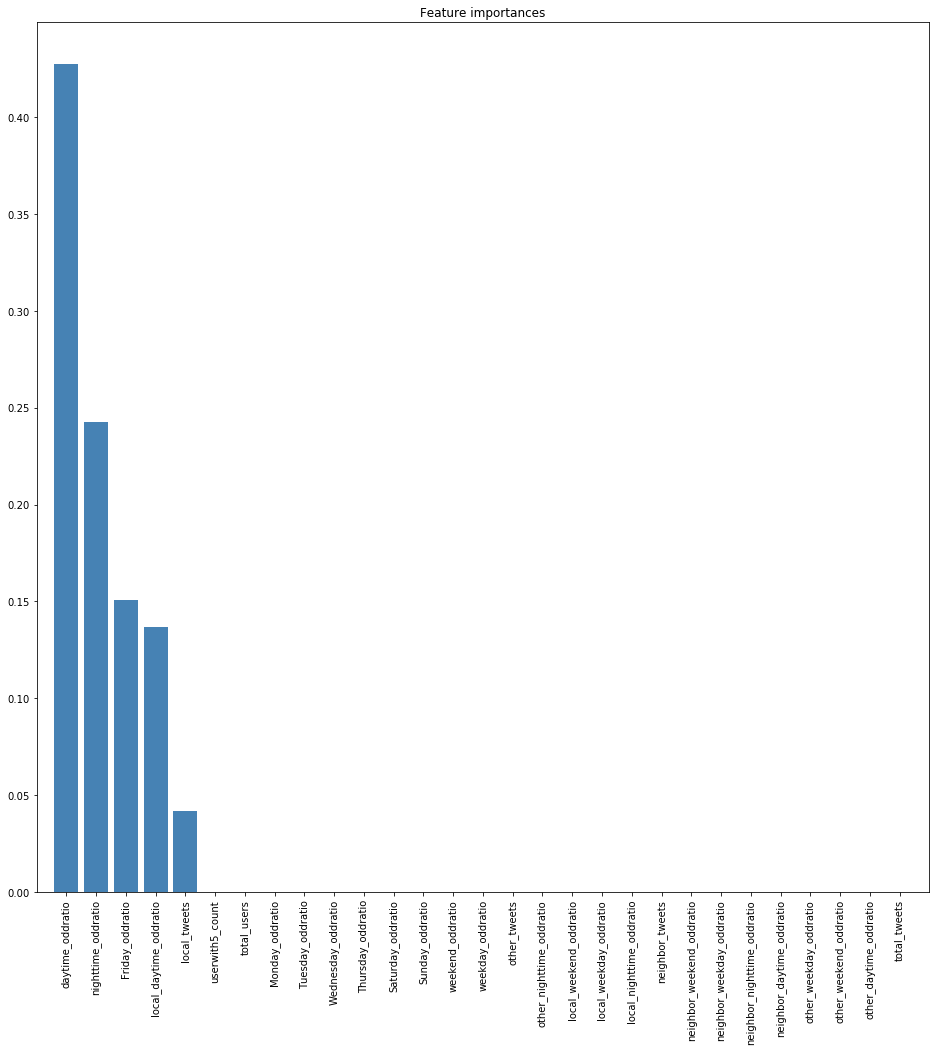

place1_target trainscore:  0.874599542334 testscore:  0.868729989328 F1:  0.0340632603406 
 [[2718    6]
 [ 391    7]]


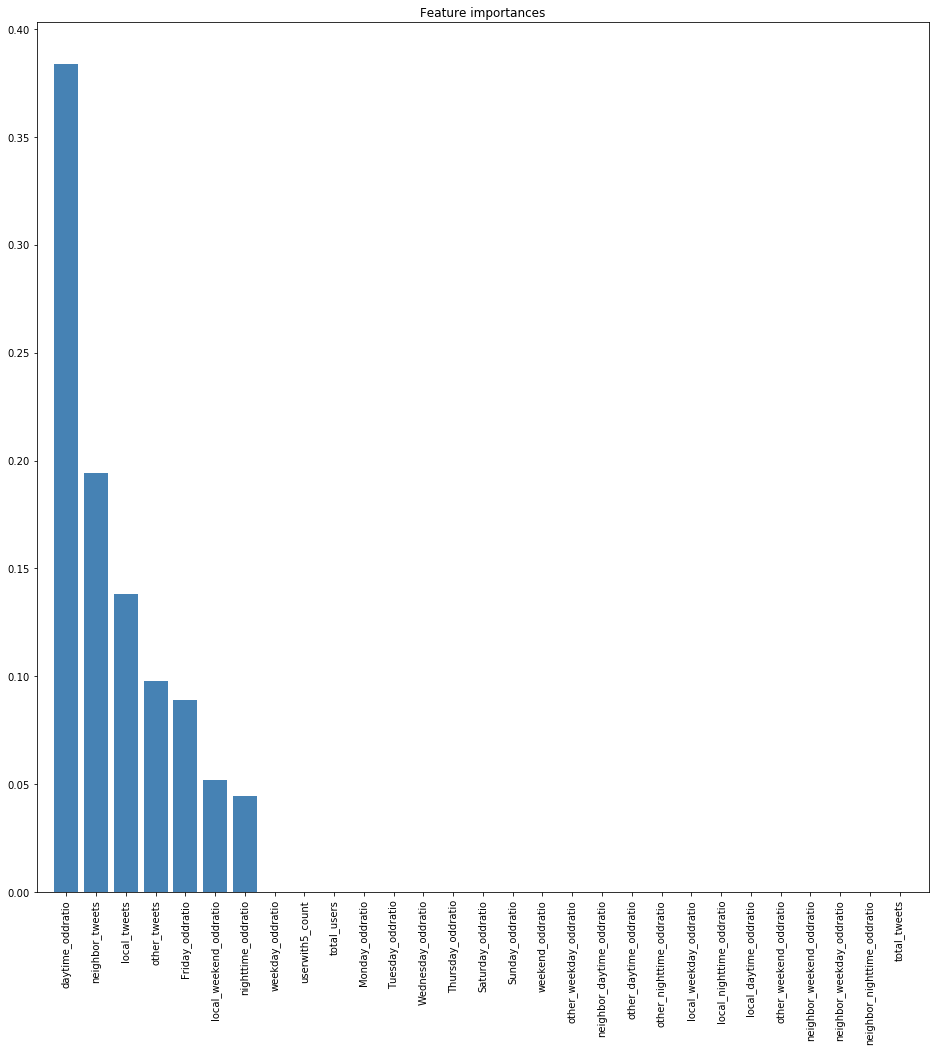

place2_target trainscore:  0.658123569794 testscore:  0.635005336179 F1:  0.581957773512 
 [[1275  638]
 [ 451  758]]


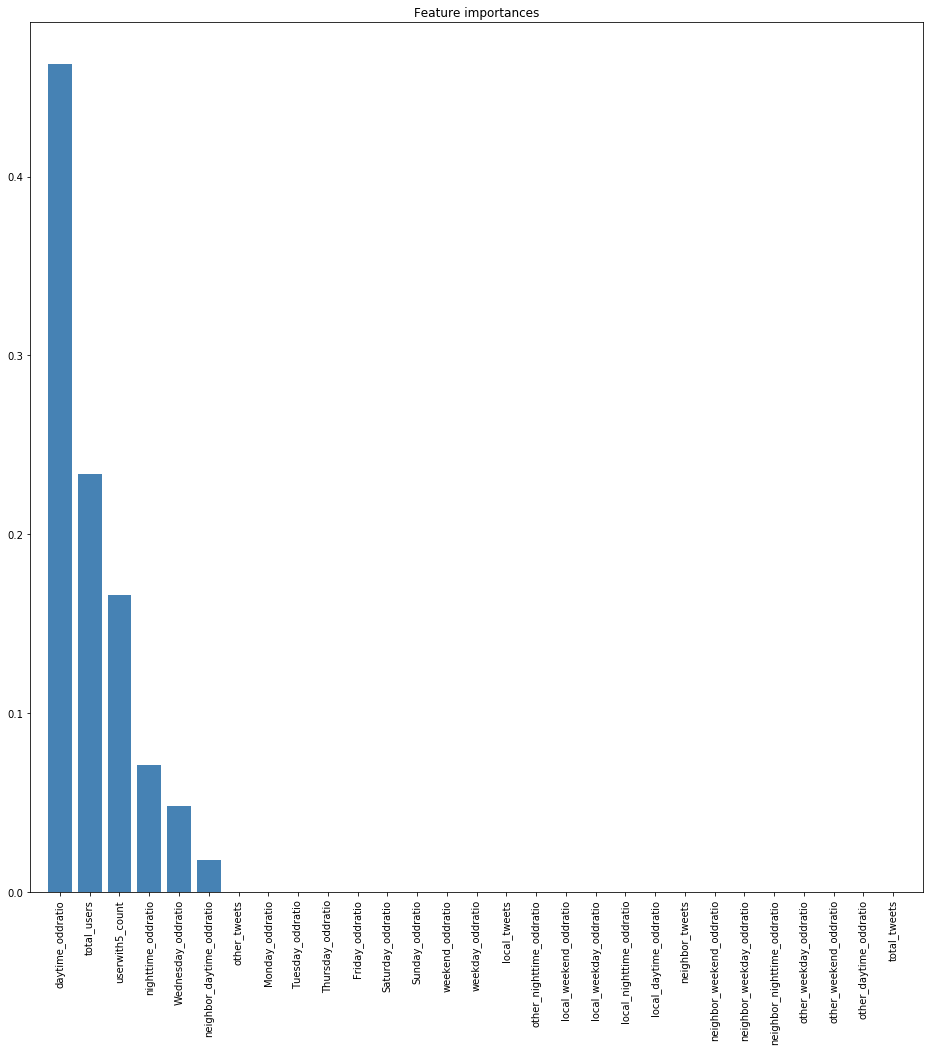

gent16_target trainscore:  0.94004576659 testscore:  0.946638207044 F1:  0.0621761658031 
 [[2935    2]
 [ 179    6]]


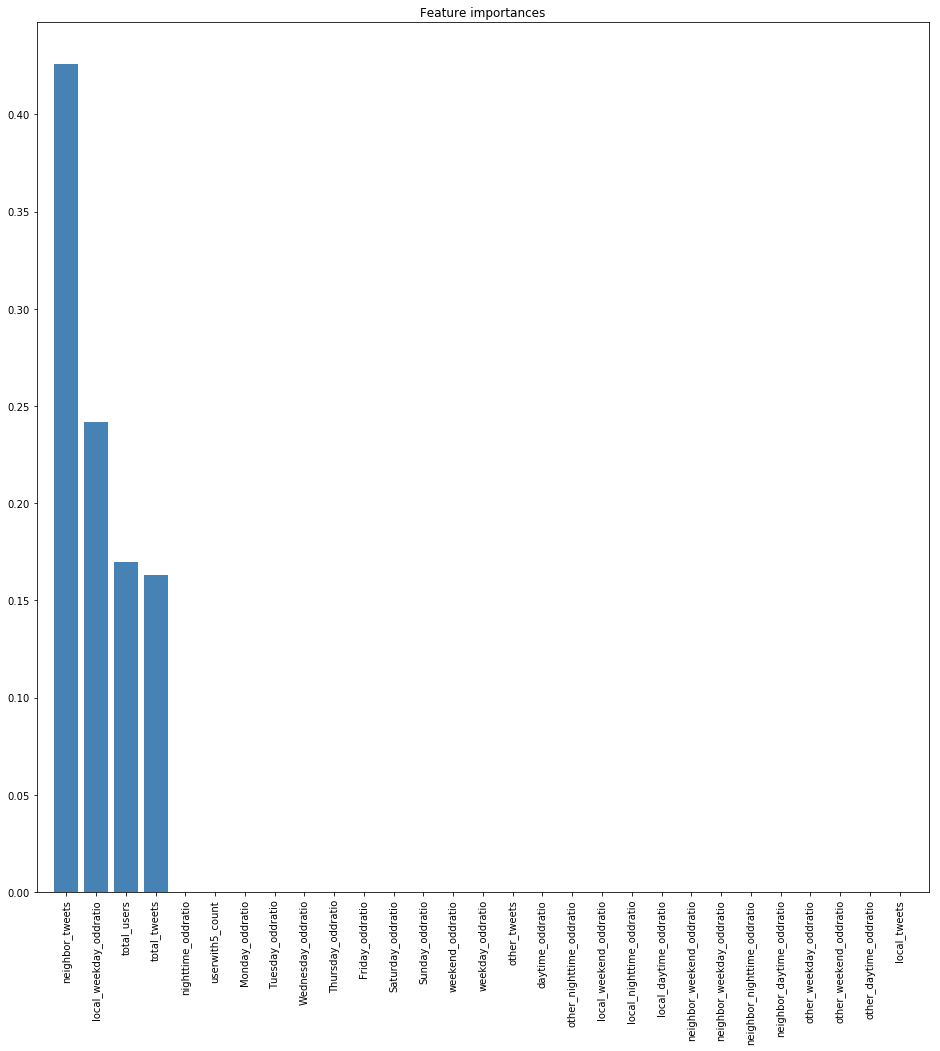

supergent_target trainscore:  0.977116704805 testscore:  0.980789754536 F1:  0.0555555555556 
 [[3052    1]
 [  67    2]]


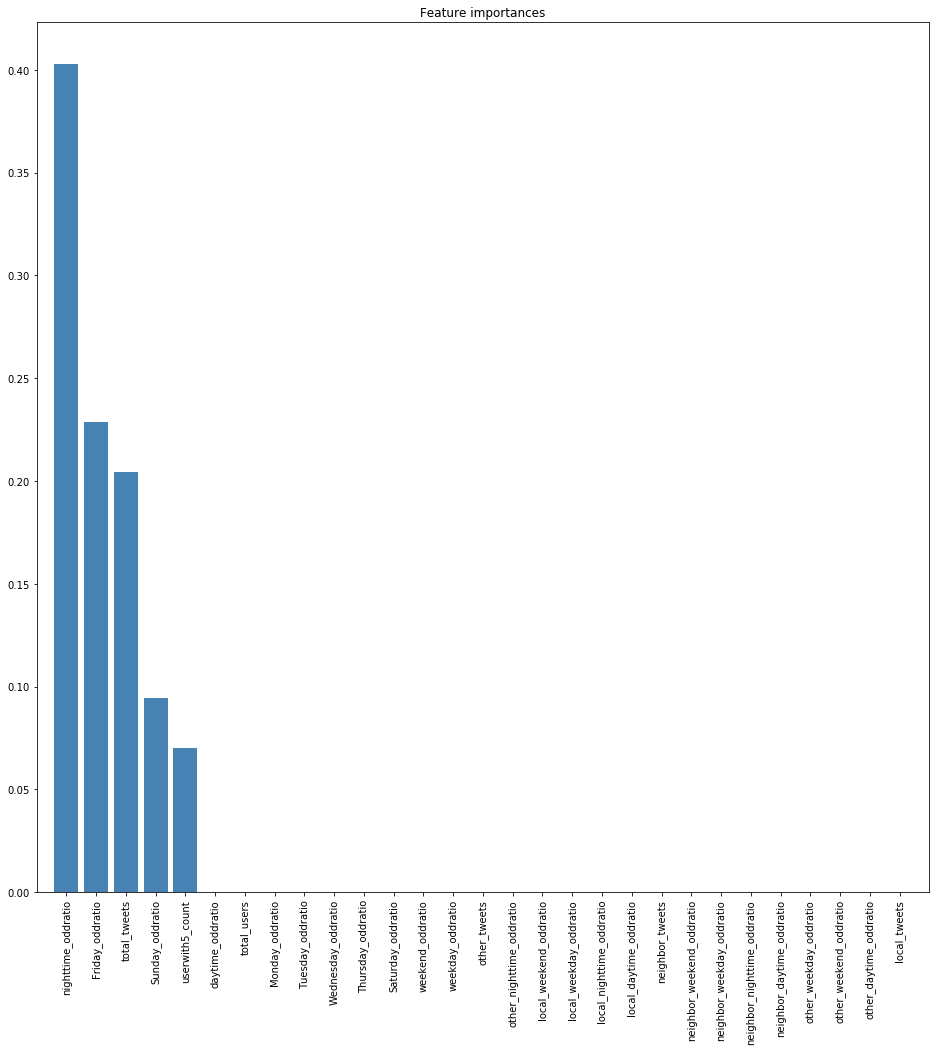

In [100]:
#targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets = [full[['Type_binary']], full[['pct_ch_hinc00_16_binary']], full[['pct_ch_medhval00_16_binary']], full[['pct_ch_medrent00_16_binary']], full[['gent00_16_y']], full[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
resdicttwitter = []
for n in targets1: 
    modeldata1= binary_subset
    modeltarget1 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata1, modeltarget1, test_size = 0.3, random_state = 1)
    clf =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf.score(modeldata_train, modeltarget_train)
    testscore = clf.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget1, clf.predict(modeldata1))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n' , metrics.confusion_matrix(modeltarget1, clf.predict(modeldata1)))
    featureImportancePlot(clf, modeldata1.columns)
    resdicttwitter.append({'featureset': 'twitteronly', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

In [107]:
resultsdf = resultsdf.append(resdicttwitter)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Building a more robust model by adding census and other features to reduce the number of FN results and improve the number of TP results

In [43]:
#list(full.columns)

In [43]:
centwitter = all[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
 ## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
  'Type_binary',
 'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [44]:
centwitter.shape

(3122, 46)

In [56]:
#centwitter=centwitter.dropna()

In [49]:
centwitter.iloc[:, 0:-6].head()

,total_tweets,userwith5_count,total_users,Monday_oddratio,Tuesday_oddratio,Wednesday_oddratio,Thursday_oddratio,Friday_oddratio,Saturday_oddratio,Sunday_oddratio,...,nbrpercentage,visitorpercentage,medrent00,medhval00,percol00,per_rent_00,pernwh00,hinc00,TOD,carcommuters_00
0,58602,1100,4767,0.144398,0.144620,0.148050,0.142862,0.142094,0.133835,0.144142,...,0.090458,0.436948,988.000000,273900.0000,0.231504,0.066202,0.072632,120523.998898,0.0,0.875731
1,61747,810,3917,0.152639,0.159668,0.146096,0.151473,0.130516,0.126727,0.132881,...,0.097640,0.316193,808.000000,192600.0000,0.155385,0.439133,0.212597,72720.400000,1.0,0.736007
2,12882,257,1214,0.138643,0.151917,0.129405,0.134063,0.136004,0.158361,0.151374,...,0.108524,0.365782,851.472538,160730.8299,0.132740,0.221931,0.228813,73386.248102,0.0,0.000000
3,5277,115,578,0.139473,0.124503,0.158234,0.165245,0.138336,0.137768,0.136441,...,0.110290,0.353421,933.000000,356300.0000,0.284779,0.847303,0.617156,84320.400000,0.0,0.180912
4,40040,522,1678,0.131319,0.129970,0.132293,0.137512,0.118906,0.162363,0.187637,...,0.131618,0.218107,649.000000,173700.0000,0.058760,0.791447,0.851364,42744.550000,0.0,0.384564


In [47]:
CTmodeldata=centwitter.iloc[:, 0:-6]
CTmodeltarget=centwitter.iloc[:,-6:]

In [109]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targetsCT = [centwitter[['Type_binary']], centwitter[['pct_ch_hinc00_16_binary']], centwitter[['pct_ch_medhval00_16_binary']], centwitter[['pct_ch_medrent00_16_binary']], centwitter[['gent00_16_y']], centwitter[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
resdicttwittercen = []
for n in targetsCT: 
    modeldataCT= CTmodeldata
    modeltargetCT = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldataCT, modeltargetCT, test_size = 0.3, random_state = 1)
    clfCT =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clfCT.score(modeldata_train, modeltarget_train)
    testscore = clfCT.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltargetCT, clfCT.predict(modeldataCT))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltargetCT, clfCT.predict(modeldataCT)) )
    resdicttwittercen.append({'featureset': 'centwitter', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    #featureImportancePlot(clf2, modeldata2.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.871395881007 testscore:  0.86552828175 F1:  0.212765957447 
 [[2660   54]
 [ 353   55]]
people_target trainscore:  0.95652173913 testscore:  0.958377801494 F1:  0.0428571428571 
 [[2985    3]
 [ 131    3]]
place1_target trainscore:  0.875972540046 testscore:  0.830309498399 F1:  0.54641350211 
 [[2433  291]
 [ 139  259]]
place2_target trainscore:  0.862700228833 testscore:  0.836712913554 F1:  0.822003929273 
 [[1623  290]
 [ 163 1046]]
gent16_target trainscore:  0.939588100686 testscore:  0.923159018143 F1:  0.43956043956 
 [[2838   99]
 [ 105   80]]
supergent_target trainscore:  0.993592677346 testscore:  0.985058697972 F1:  0.802816901408 
 [[3037   16]
 [  12   57]]


In [110]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targetsCT =  [centwitter[['Type_binary']], centwitter[['pct_ch_hinc00_16_binary']], centwitter[['pct_ch_medhval00_16_binary']], centwitter[['pct_ch_medrent00_16_binary']], centwitter[['gent00_16_y']], centwitter[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
for n in targetsCT: 
    modeldataCT= CTmodeldata
    modeltargetCT = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldataCT, modeltargetCT, test_size = 0.3, random_state = 1)
    logit_CT = LogisticRegression(C = 10000)
    logit_CT.fit(modeldata_train, modeltarget_train)
    trainscore = logit_CT.score(modeldata_train, modeltarget_train)
    testscore = logit_CT.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltargetCT, clfCT.predict(modeldataCT))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltargetCT, clfCT.predict(modeldataCT)) )
    resdicttwittercen.append({'featureset': 'centwitter', 'binaryvariable': targetnames[a], 'modeltype': 'Logit', 'fscore': f1score})
    # featureImportancePlot(logit_2, modeldata2.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870022883295 testscore:  0.867662753469 F1:  0.004158004158 
 [[2642   72]
 [ 407    1]]
people_target trainscore:  0.955606407323 testscore:  0.956243329776 F1:  0.0 
 [[2915   73]
 [ 134    0]]
place1_target trainscore:  0.872311212815 testscore:  0.871931696905 F1:  0.0 
 [[2651   73]
 [ 398    0]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

place2_target trainscore:  0.812356979405 testscore:  0.806830309498 F1:  0.0 
 [[1840   73]
 [1209    0]]
gent16_target trainscore:  0.936842105263 testscore:  0.947705442903 F1:  0.232558139535 
 [[2894   43]
 [ 155   30]]
supergent_target trainscore:  0.975743707094 testscore:  0.977588046958 F1:  0.802816901408 
 [[3037   16]
 [  12   57]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

# THE BELOW RF MODELS COULD PROBABLY BE TUNED

In [111]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets2 =  [centwitter[['Type_binary']], centwitter[['pct_ch_hinc00_16_binary']], centwitter[['pct_ch_medhval00_16_binary']], centwitter[['pct_ch_medrent00_16_binary']], centwitter[['gent00_16_y']], centwitter[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
seed = 5
for n in targetsCT: 
    modeldataCT= CTmodeldata
    modeltargetCT = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldataCT, modeltargetCT, test_size = 0.3, random_state = 1)
    param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
    rfCT=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rfCT = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rfCT.fit(modeldata_train, modeltarget_train)
    trainscore = rfCT.score(modeldata_train, modeltarget_train)
    testscore = rfCT.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltargetCT, clfCT.predict(modeldataCT))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltargetCT, clfCT.predict(modeldataCT)) )
    # featureImportancePlot(rf2, modeldata2.columns)
    resdicttwittercen.append({'featureset': 'centwitter', 'binaryvariable': targetnames[a], 'modeltype': 'RF', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870022883295 testscore:  0.867662753469 F1:  0.004158004158 
 [[2642   72]
 [ 407    1]]
people_target trainscore:  0.956064073227 testscore:  0.960512273212 F1:  0.0 
 [[2915   73]
 [ 134    0]]
place1_target trainscore:  0.876887871854 testscore:  0.869797225187 F1:  0.0 
 [[2651   73]
 [ 398    0]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

place2_target trainscore:  0.870938215103 testscore:  0.847385272145 F1:  0.0 
 [[1840   73]
 [1209    0]]
gent16_target trainscore:  0.937299771167 testscore:  0.948772678762 F1:  0.232558139535 
 [[2894   43]
 [ 155   30]]
supergent_target trainscore:  0.985812356979 testscore:  0.983991462113 F1:  0.802816901408 
 [[3037   16]
 [  12   57]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

In [113]:
resultsdf = resultsdf.append(resdicttwittercen)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Incorporating Distance features

Distance features to high visitor tracts, high tweet tract, and high income neighborhoods were added based on the findings in our literature review and data exploration

In [54]:
dist=pd.read_csv('Data/twitter_distance.csv', index_col=0)

In [55]:
dist.columns

Index(['geoid', 'distToHighVisitorTract', 'distToHighTweetTract', 'distToMHI'], dtype='object')

In [58]:
withdist=all.merge(dist, right_on='geoid', left_on='geojoin')

In [60]:
distdata=withdist[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
## dist features
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
## dependent variables
  'Type_binary',
  'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [61]:
distdata = distdata.dropna()

[TN, FP][FN, TP]
binary trainscore:  0.871606074551 testscore:  0.863733905579 F1:  0.0145631067961 
 [[2696    1]
 [ 405    3]]


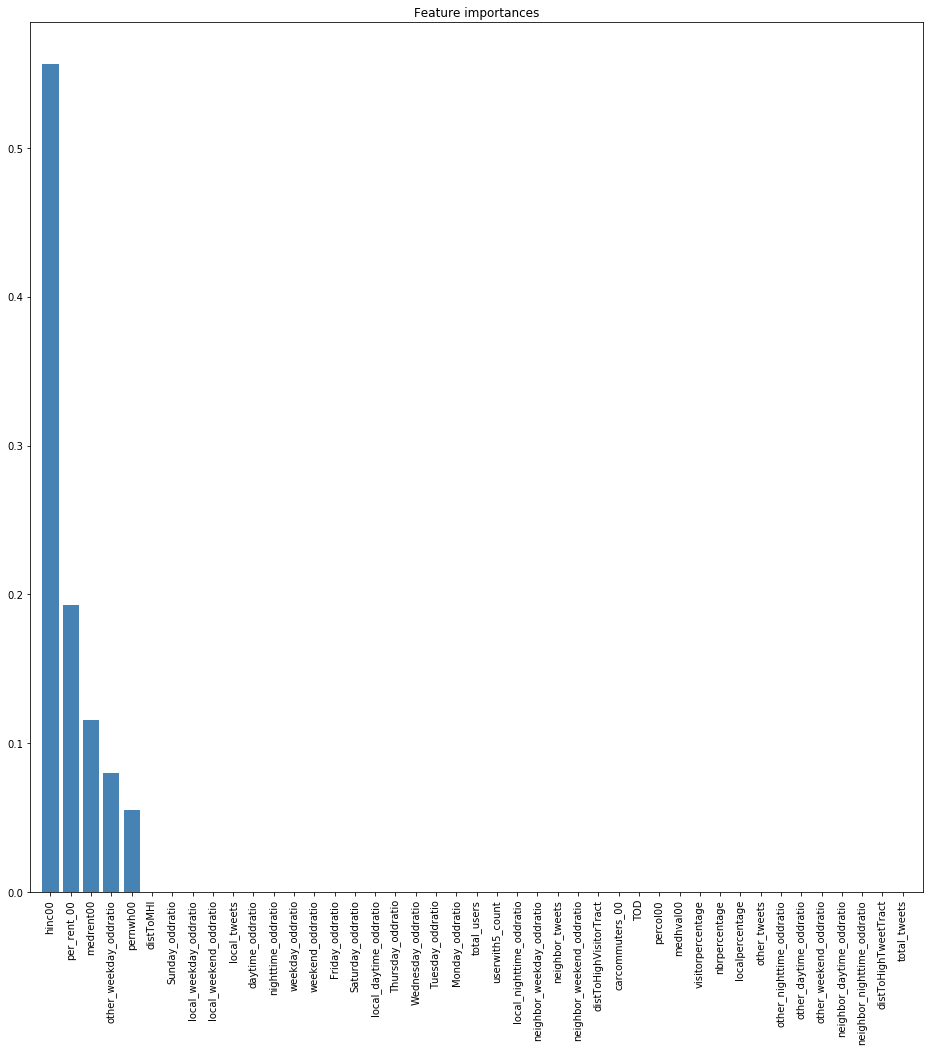

people_target trainscore:  0.9608835711 testscore:  0.93347639485 F1:  0.441064638783 
 [[2900   71]
 [  76   58]]


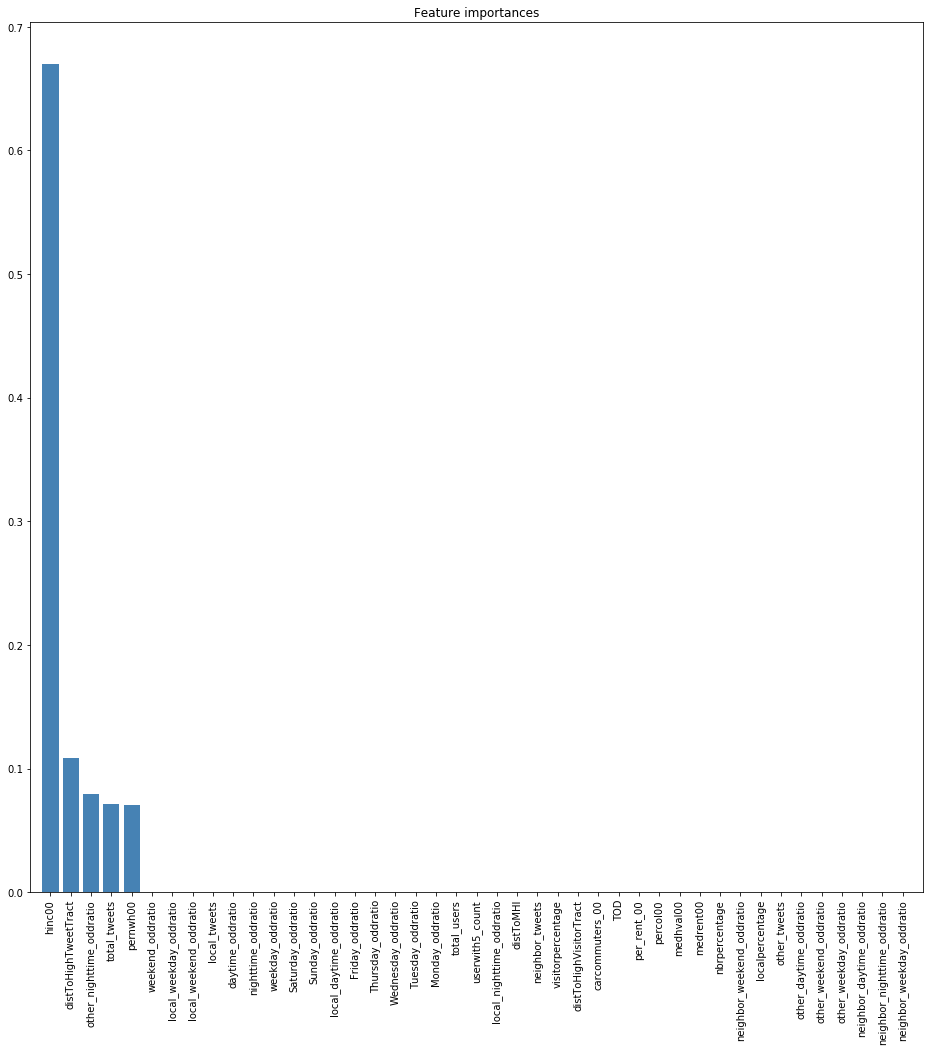

place1_target trainscore:  0.895996318454 testscore:  0.874463519313 F1:  0.331384015595 
 [[2677   30]
 [ 313   85]]


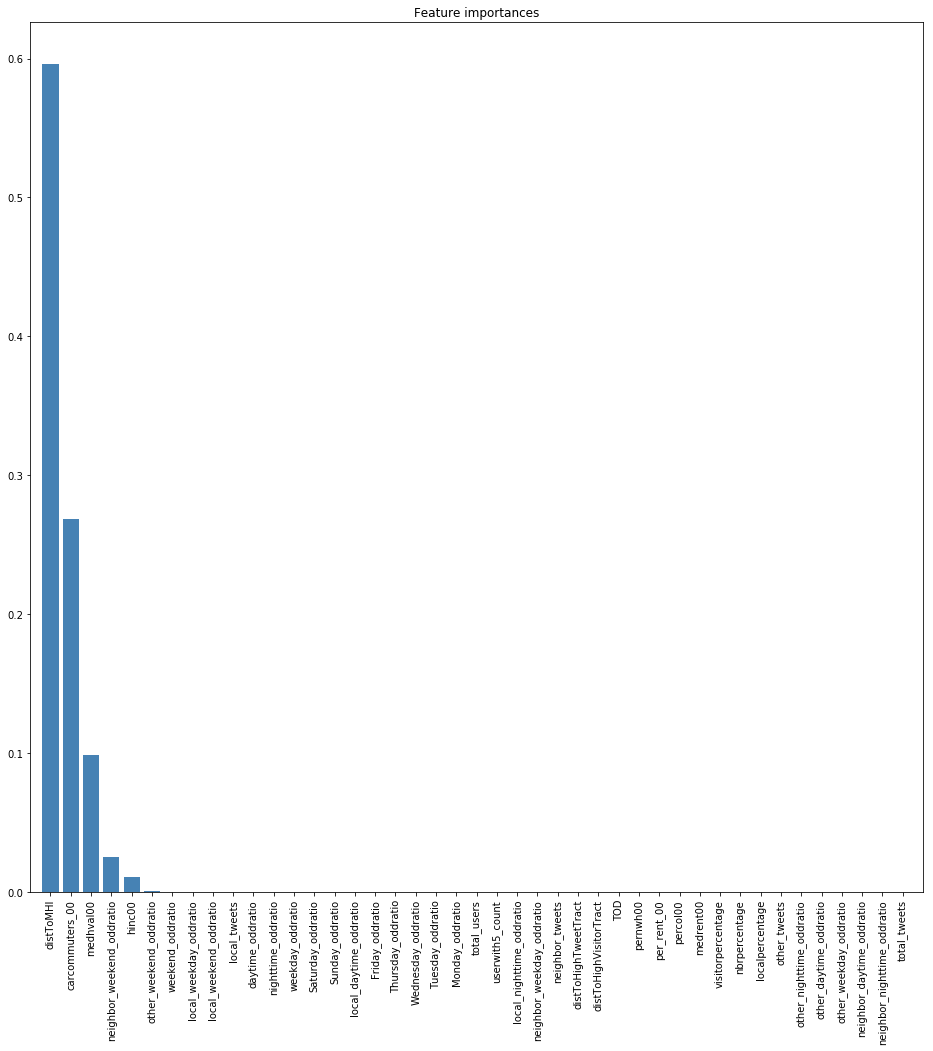

place2_target trainscore:  0.993097100782 testscore:  0.992489270386 F1:  0.990946502058 
 [[1879   19]
 [   3 1204]]


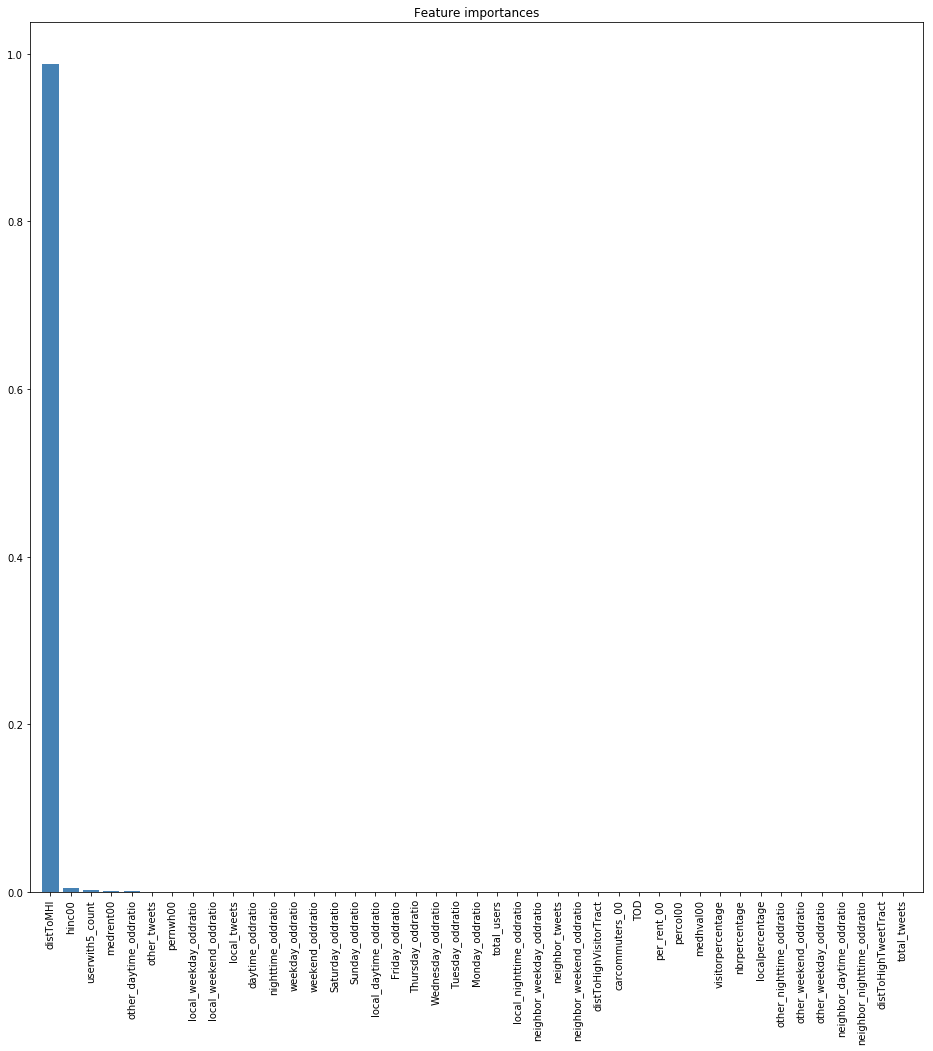

gent16_target trainscore:  0.942936033134 testscore:  0.913090128755 F1:  0.450402144772 
 [[2816  105]
 [ 100   84]]


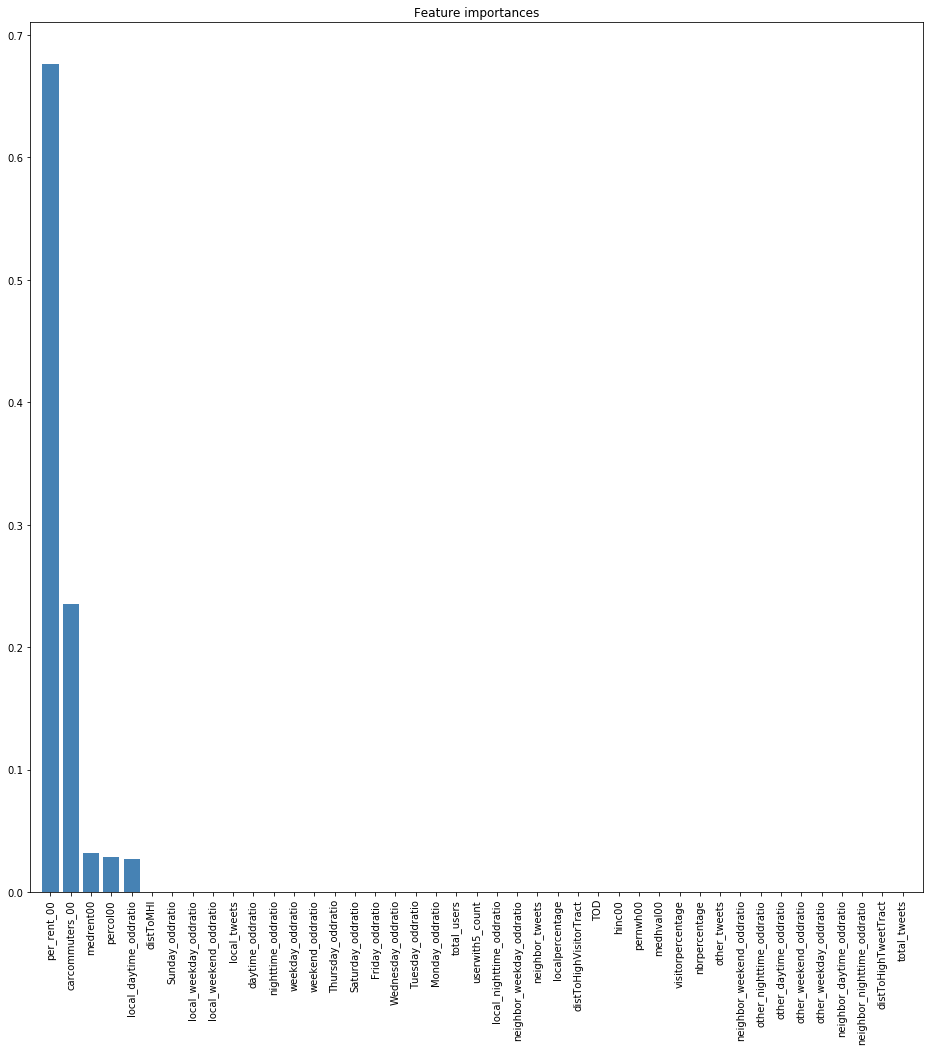

supergent_target trainscore:  0.992636907501 testscore:  0.982832618026 F1:  0.780821917808 
 [[3016   23]
 [   9   57]]


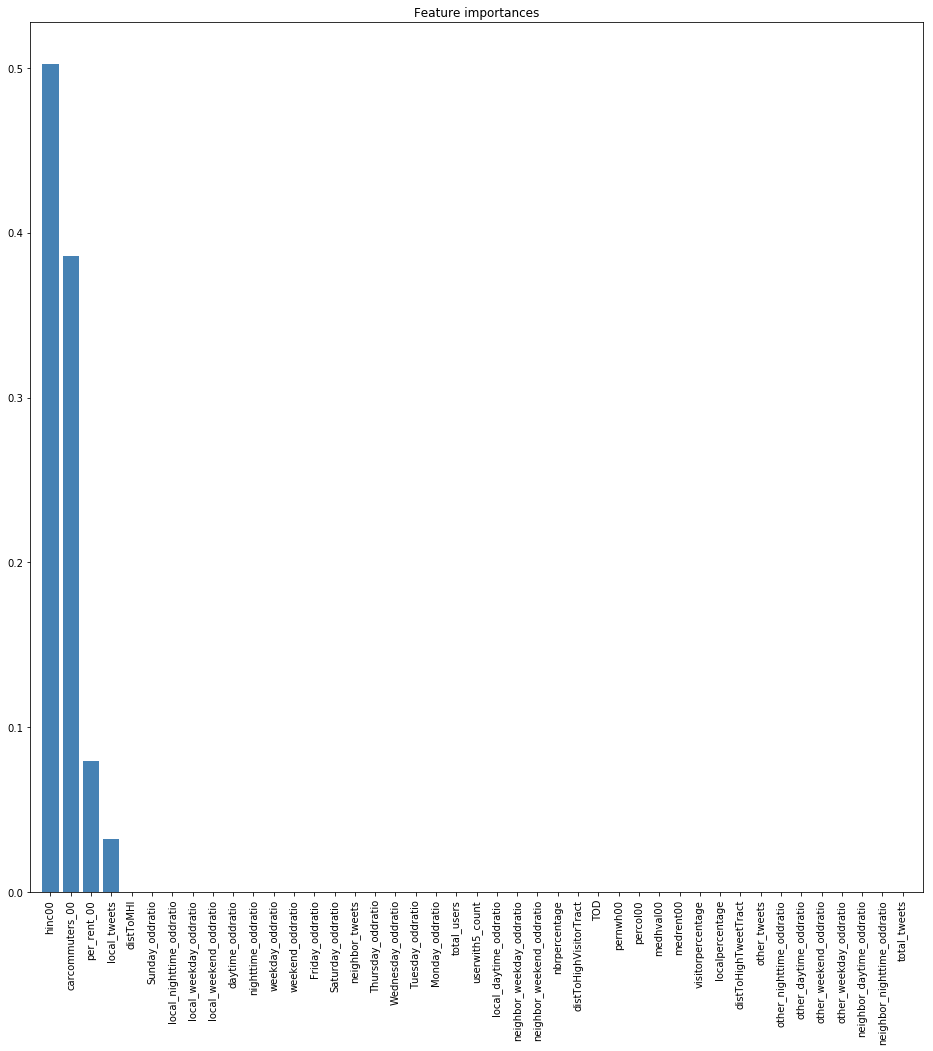

In [117]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
resdist = []
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    clf3 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf3.score(modeldata_train, modeltarget_train)
    testscore = clf3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget3, clf3.predict(modeldata3))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, clf3.predict(modeldata3)) )
    featureImportancePlot(clf3, modeldata3.columns)
    resdist.append({'featureset': 'CT + distances', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

In [118]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    logit_3 = LogisticRegression(C = 10000)
    logit_3.fit(modeldata_train, modeltarget_train)
    trainscore = logit_3.score(modeldata_train, modeltarget_train)
    testscore = logit_3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget3, logit_3.predict(modeldata3))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, logit_3.predict(modeldata3)) )
    #featureImportancePlot(logit_3, modeldata3.columns)
    resdist.append({'featureset': 'CT + distances', 'binaryvariable': targetnames[a], 'modeltype': 'Logit', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870685687989 testscore:  0.863733905579 F1:  0.0 
 [[2697    0]
 [ 408    0]]
people_target trainscore:  0.957662218132 testscore:  0.952789699571 F1:  0.116883116883 
 [[2960   11]
 [ 125    9]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

place1_target trainscore:  0.876668200644 testscore:  0.859442060086 F1:  0.0869565217391 
 [[2687   20]
 [ 379   19]]
place2_target trainscore:  0.797975149563 testscore:  0.826180257511 F1:  0.729887640449 
 [[1692  206]
 [ 395  812]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

gent16_target trainscore:  0.940635066728 testscore:  0.938841201717 F1:  0.0106382978723 
 [[2918    3]
 [ 183    1]]
supergent_target trainscore:  0.980211688909 testscore:  0.972103004292 F1:  0.224719101124 
 [[3026   13]
 [  56   10]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    rf3=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf3 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf3.fit(modeldata_train, modeltarget_train)
    trainscore = rf3.score(modeldata_train, modeltarget_train)
    testscore = rf3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget3, rf3.predict(modeldata3))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, rf3.predict(modeldata3)) )
   # featureImportancePlot(rf3, modeldata3.columns)
    resdist.append({'featureset': 'CT + distances', 'binaryvariable': targetnames[a], 'modeltype': 'RF', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870685687989 testscore:  0.863733905579 F1:  0.0 
 [[2697    0]
 [ 408    0]]
people_target trainscore:  0.959963184538 testscore:  0.950643776824 F1:  0.0148148148148 
 [[2971    0]
 [ 133    1]]
place1_target trainscore:  0.87896916705 testscore:  0.856223175966 F1:  0.00501253132832 
 [[2707    0]
 [ 397    1]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "

place2_target trainscore:  0.973768982973 testscore:  0.978540772532 F1:  0.967524251371 
 [[1881   17]
 [  60 1147]]
gent16_target trainscore:  0.94155545329 testscore:  0.938841201717 F1:  0.010752688172 
 [[2920    1]
 [ 183    1]]
supergent_target trainscore:  0.986194201565 testscore:  0.976394849785 F1:  0.35 
 [[3039    0]
 [  52   14]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

In [121]:
resultsdf = resultsdf.append(resdist)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [123]:
resultsdf.to_csv('Data/resultsdf.csv')

# Adding Twitter Timing and Visitor Demographics

In [66]:
pd.read_csv('Data/twitter_visitor_edu_inc.csv', index_col=0)

,tract,inc,percent_inc,edu,percent_edu
0,9.001010e+09,high,32.337165,high,29.961686
1,9.001010e+09,high,32.337165,low,6.245211
2,9.001010e+09,high,32.337165,med,11.264368
3,9.001010e+09,low,6.015326,high,29.961686
4,9.001010e+09,low,6.015326,low,6.245211
5,9.001010e+09,low,6.015326,med,11.264368
6,9.001010e+09,med,9.118774,high,29.961686
7,9.001010e+09,med,9.118774,low,6.245211
8,9.001010e+09,med,9.118774,med,11.264368
9,9.001010e+09,high,12.241888,high,12.157606


In [69]:
pd.read_csv('Data/twitter_tract_count_2012_2015.csv', index_col=0)

,year,tract,u_id
0,2012.0,9.001010e+09,668
1,2012.0,9.001010e+09,2437
2,2012.0,9.001010e+09,476
3,2012.0,9.001010e+09,494
4,2012.0,9.001010e+09,1355
5,2012.0,9.001010e+09,1357
6,2012.0,9.001011e+09,1885
7,2012.0,9.001011e+09,372
8,2012.0,9.001011e+09,1007
9,2012.0,9.001011e+09,1139


# Adding new census features from 2000

In [79]:
newcen00 = pd.read_csv('Data/tract00_feature.csv', index_col=0)
newcen00['geojoin']=newcen00['geoid'].astype(float)

In [80]:
newcen00subset = newcen00[['geoid', 'geojoin','pop00', 'phisp00', 'pnhblk00', 'pasian00', 'popden00', 'unempden00', 'pag25up00']]

In [82]:
withnewcen = withdist.merge(newcen00subset, right_on='geojoin', left_on='geojoin')

In [85]:
withnewcenmodel = withnewcen[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00',
 #'Type_binary',
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
  # new census features
  'pop00_y', 
  'phisp00',
  'pnhblk00', 
  'pasian00', 
 'popden00',
  'unempden00', 
  'pag25up00',
 #'HD03_S08'
  'Type_binary',
  'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16'
   ]]

In [86]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets4 = [withnewcenmodel[['Type_binary']], withnewcenmodel[['pct_ch_hinc00_16_binary']], withnewcenmodel[['pct_ch_medhval00_16_binary']], withnewcenmodel[['pct_ch_medrent00_16_binary']], withnewcenmodel[['gent00_16_y']], withnewcenmodel[['Supergent16']]]
withnewcenmodeldata = withnewcenmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets4: 
    modeldata4= withnewcenmodeldata
    modeltarget4 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata4, modeltarget4, test_size = 0.3, random_state = 1)
    clf4 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf4.score(modeldata_train, modeltarget_train)
    testscore = clf4.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget4, clf4.predict(modeldata4))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget4, clf4.predict(modeldata4)) )
    #featureImportancePlot(clf4, modeldata4.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.875747814082 testscore:  0.857296137339 F1:  0.0692840646651 
 [[2687   10]
 [ 393   15]]
people_target trainscore:  0.9608835711 testscore:  0.93347639485 F1:  0.441064638783 
 [[2900   71]
 [  76   58]]
place1_target trainscore:  0.895996318454 testscore:  0.869098712446 F1:  0.271966527197 
 [[2692   15]
 [ 333   65]]
place2_target trainscore:  0.993097100782 testscore:  0.992489270386 F1:  0.990953947368 
 [[1878   20]
 [   2 1205]]
gent16_target trainscore:  0.94155545329 testscore:  0.93669527897 F1:  0.0106382978723 
 [[2918    3]
 [ 183    1]]
supergent_target trainscore:  0.994017487345 testscore:  0.984978540773 F1:  0.796992481203 
 [[3025   14]
 [  13   53]]


In [87]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets4 = [withnewcenmodel[['Type_binary']], withnewcenmodel[['pct_ch_hinc00_16_binary']], withnewcenmodel[['pct_ch_medhval00_16_binary']], withnewcenmodel[['pct_ch_medrent00_16_binary']], withnewcenmodel[['gent00_16_y']], withnewcenmodel[['Supergent16']]]
withnewcenmodeldata = withnewcenmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets4: 
    modeldata4= withnewcenmodeldata
    modeltarget4 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata4, modeltarget4, test_size = 0.3, random_state = 1)
    logit_4 = LogisticRegression(C = 10000)
    logit_4.fit(modeldata_train, modeltarget_train)
    trainscore = logit_4.score(modeldata_train, modeltarget_train)
    testscore = logit_4.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget4, logit_4.predict(modeldata4))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget4, logit_4.predict(modeldata4)) )
    #featureImportancePlot(logit_4, modeldata4.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.869765301427 testscore:  0.857296137339 F1:  0.0325581395349 
 [[2682   15]
 [ 401    7]]
people_target trainscore:  0.955821445007 testscore:  0.948497854077 F1:  0.04 
 [[2958   13]
 [ 131    3]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

place1_target trainscore:  0.878048780488 testscore:  0.850858369099 F1:  0.195219123506 
 [[2652   55]
 [ 349   49]]
place2_target trainscore:  0.819144040497 testscore:  0.818669527897 F1:  0.740774907749 
 [[1740  158]
 [ 404  803]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

gent16_target trainscore:  0.941095260009 testscore:  0.938841201717 F1:  0.0 
 [[2920    1]
 [ 184    0]]
supergent_target trainscore:  0.978831109066 testscore:  0.969957081545 F1:  0.177777777778 
 [[3023   16]
 [  58    8]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets4 = [withnewcenmodel[['Type_binary']], withnewcenmodel[['pct_ch_hinc00_16_binary']], withnewcenmodel[['pct_ch_medhval00_16_binary']], withnewcenmodel[['pct_ch_medrent00_16_binary']], withnewcenmodel[['gent00_16_y']], withnewcenmodel[['Supergent16']]]
withnewcenmodeldata = withnewcenmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets4: 
    modeldata4= withnewcenmodeldata
    modeltarget4 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata4, modeltarget4, test_size = 0.3, random_state = 1)
    rf4=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf4 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf4.fit(modeldata_train, modeltarget_train)
    trainscore = rf4.score(modeldata_train, modeltarget_train)
    testscore = rf4.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget4, rf4.predict(modeldata4))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget4, rf4.predict(modeldata4)) )
    #featureImportancePlot(rf4, modeldata4.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.873446847676 testscore:  0.865879828326 F1:  0.047619047619 
 [[2695    2]
 [ 398   10]]
people_target trainscore:  0.959502991256 testscore:  0.950643776824 F1:  0.0 
 [[2971    0]
 [ 134    0]]
place1_target trainscore:  0.881270133456 testscore:  0.857296137339 F1:  0.0345679012346 
 [[2707    0]
 [ 391    7]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

place2_target trainscore:  0.971928209848 testscore:  0.973175965665 F1:  0.963743676223 
 [[1876   22]
 [  64 1143]]
gent16_target trainscore:  0.94155545329 testscore:  0.93991416309 F1:  0.0108108108108 
 [[2921    0]
 [ 183    1]]
supergent_target trainscore:  0.986194201565 testscore:  0.974248927039 F1:  0.325 
 [[3038    1]
 [  53   13]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

# FROM HERE BELOW NOT USED -- Controlling for Commercial Land Use

Many areas with high commercial property percentages see a different profile of tweets than those with mostly residential population. 

In [107]:
commercial = pd.read_csv('Data/commercial_pct.csv', index_col=0)

In [159]:
commercial.shape

(2171, 2)

In [129]:
withcomm = commercial.merge(withnewcen, right_on='geoid', left_on='geoid')

In [161]:
withcomm.shape

(756, 250)

In [130]:
withcommmodel = withcomm[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pop_00',
 'pernwh00',
 'hinc00',
 #'Type_binary',
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
   'SUBHD0201_S06',
 'SUBHD0202_S06',
 'SUBHD0203_S06',
 #'HD03_S06',
 'SUBHD0201_S07',
 'SUBHD0202_S07',
 'SUBHD0203_S07',
 #'HD03_S07',
 'SUBHD0201_S08',
 'SUBHD0202_S08',
 'SUBHD0203_S08',
 #'HD03_S08'
  'commercial_pct',
  'Type_binary',
  'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16'
   ]]

0.0    824
1.0      7
Name: Supergent16, dtype: int64

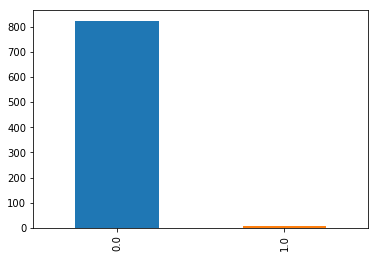

In [162]:
withnewcen['Supergent16'].value_counts().plot(kind='bar')
withnewcen['Supergent16'].value_counts()

[TN, FP][FN, TP]
binary trainscore:  0.882797731569 testscore:  0.79295154185 F1:  0.617543859649 
 [[559  55]
 [ 54  88]]


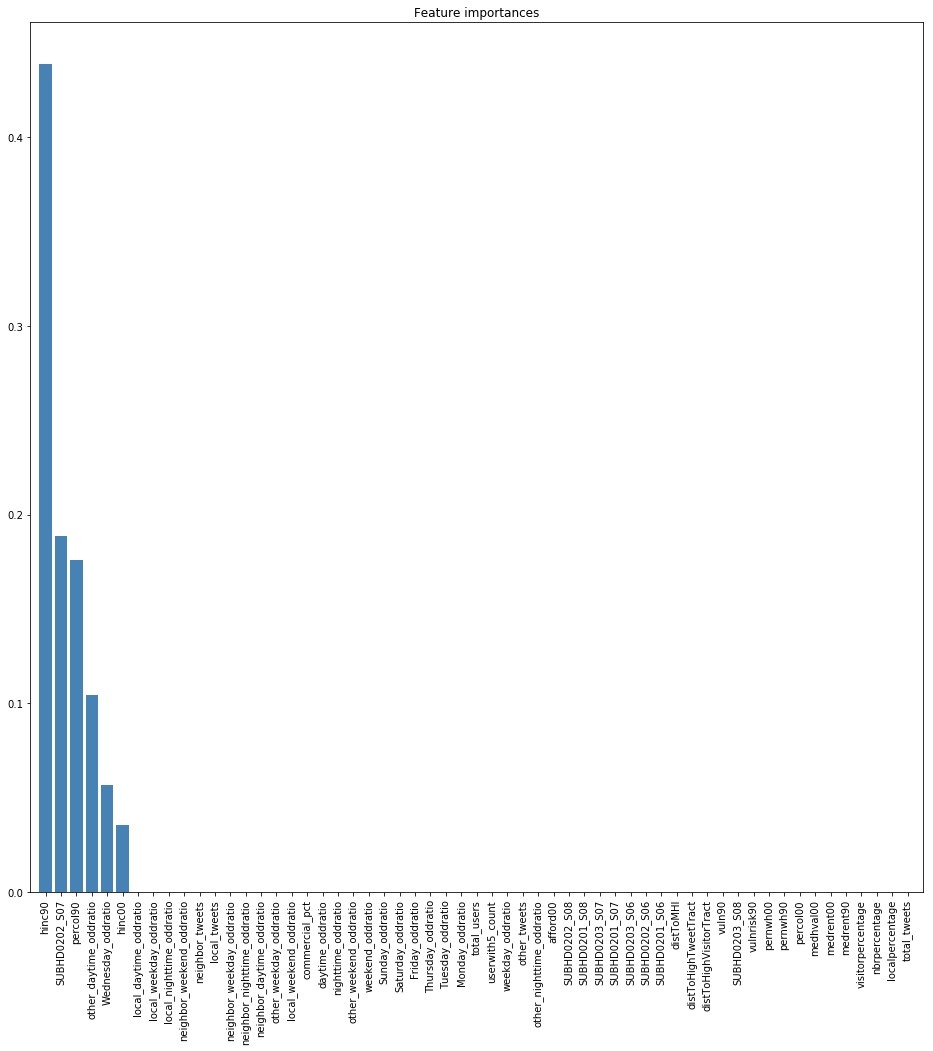

people_target trainscore:  0.87145557656 testscore:  0.819383259912 F1:  0.609318996416 
 [[562  19]
 [ 90  85]]


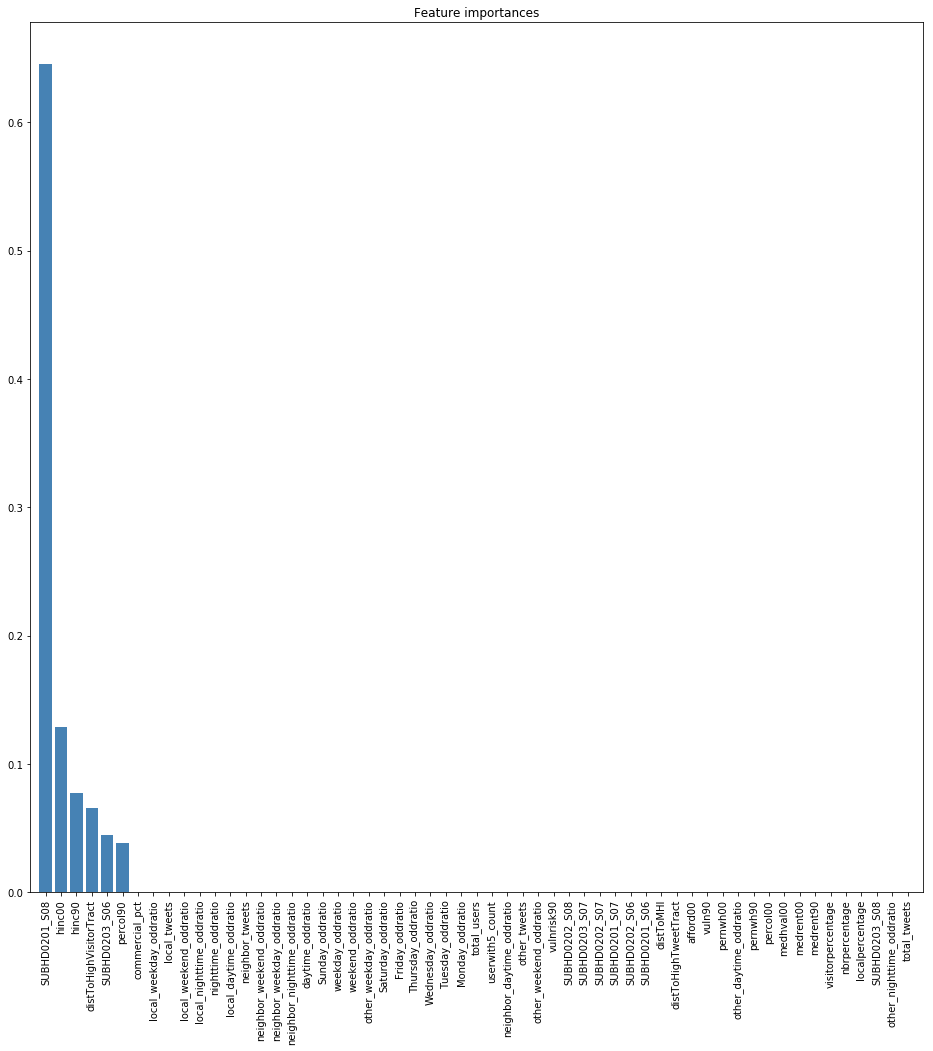

place1_target trainscore:  0.89224952741 testscore:  0.885462555066 F1:  0.674509803922 
 [[587  31]
 [ 52  86]]


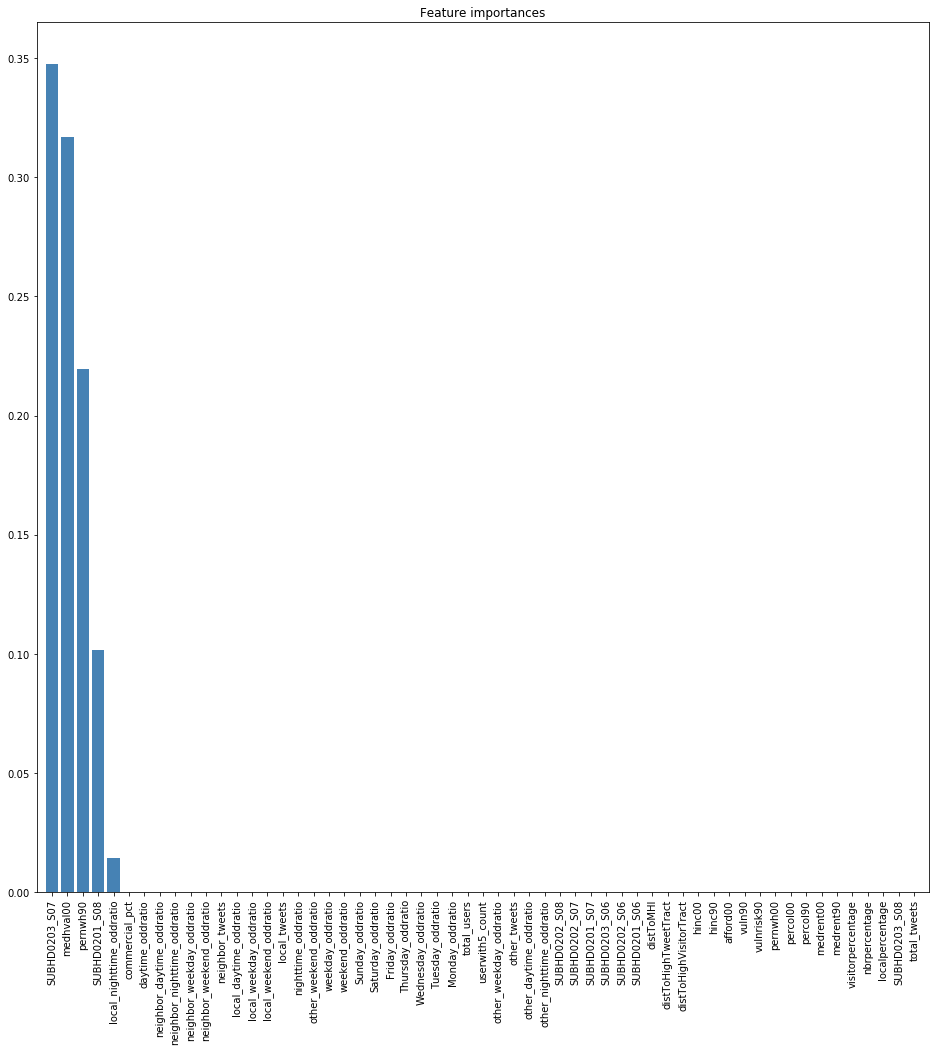

place2_target trainscore:  0.952741020794 testscore:  0.894273127753 F1:  0.966136834831 
 [[  8  45]
 [  4 699]]


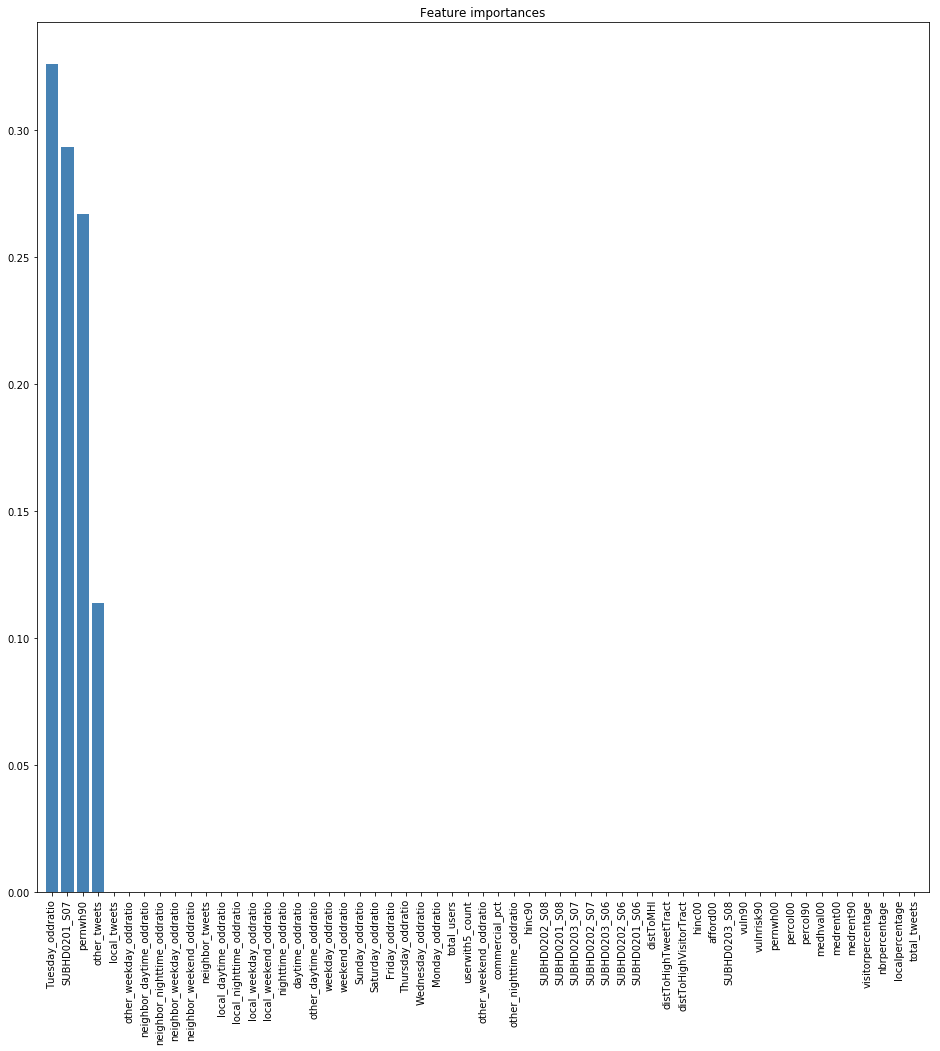

gent16_target trainscore:  0.975425330813 testscore:  0.947136563877 F1:  0.358974358974 
 [[724   3]
 [ 22   7]]


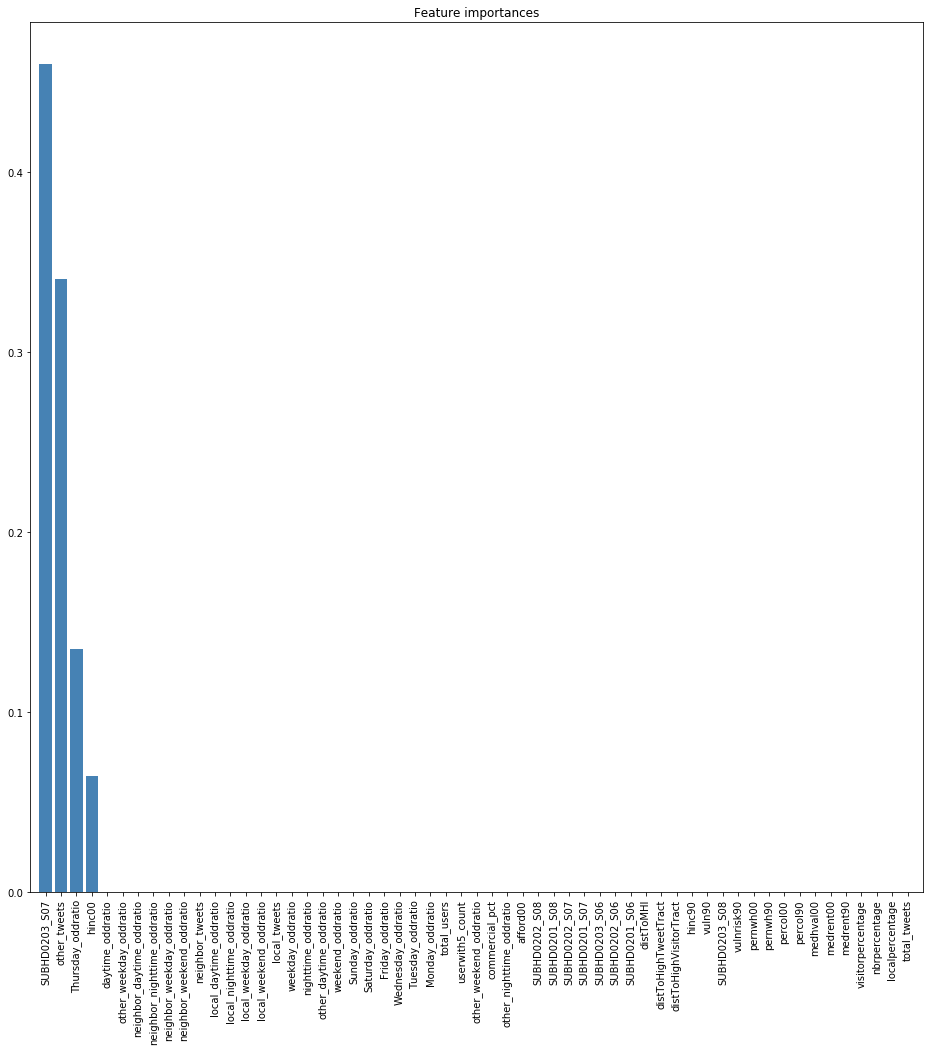

supergent_target trainscore:  1.0 testscore:  1.0 F1:  0.0 
 [[756]]


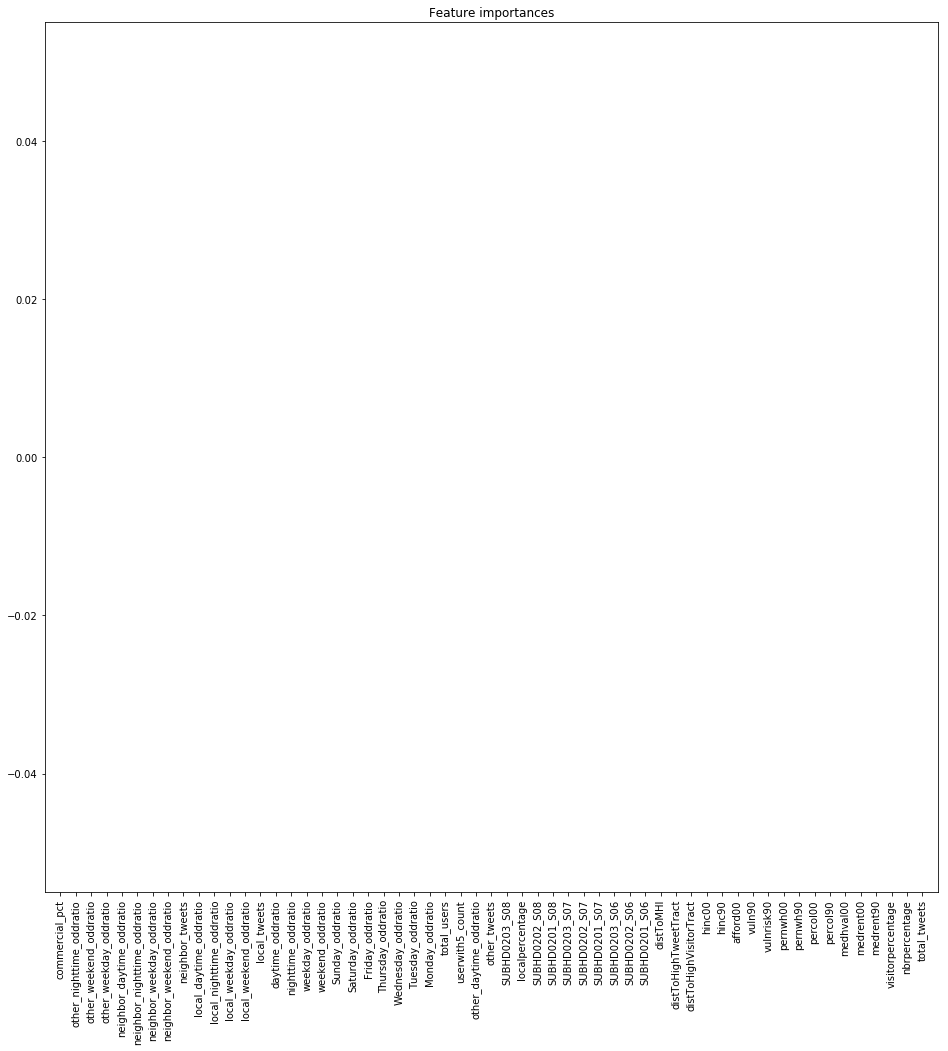

In [134]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets5 = [withcommmodel[['Type_binary']], withcommmodel[['pct_ch_hinc00_16_binary']], withcommmodel[['pct_ch_medhval00_16_binary']], withcommmodel[['pct_ch_medrent00_16_binary']], withcommmodel[['gent00_16_y']], withcommmodel[['Supergent16']]]
withcommmodeldata = withcommmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets5: 
    modeldata5= withcommmodeldata
    modeltarget5 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata5, modeltarget5, test_size = 0.3, random_state = 1)
    clf5 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf5.score(modeldata_train, modeltarget_train)
    testscore = clf5.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget5, clf5.predict(modeldata5))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget5, clf5.predict(modeldata5)) )
    featureImportancePlot(clf5, modeldata5.columns)
    a += 1

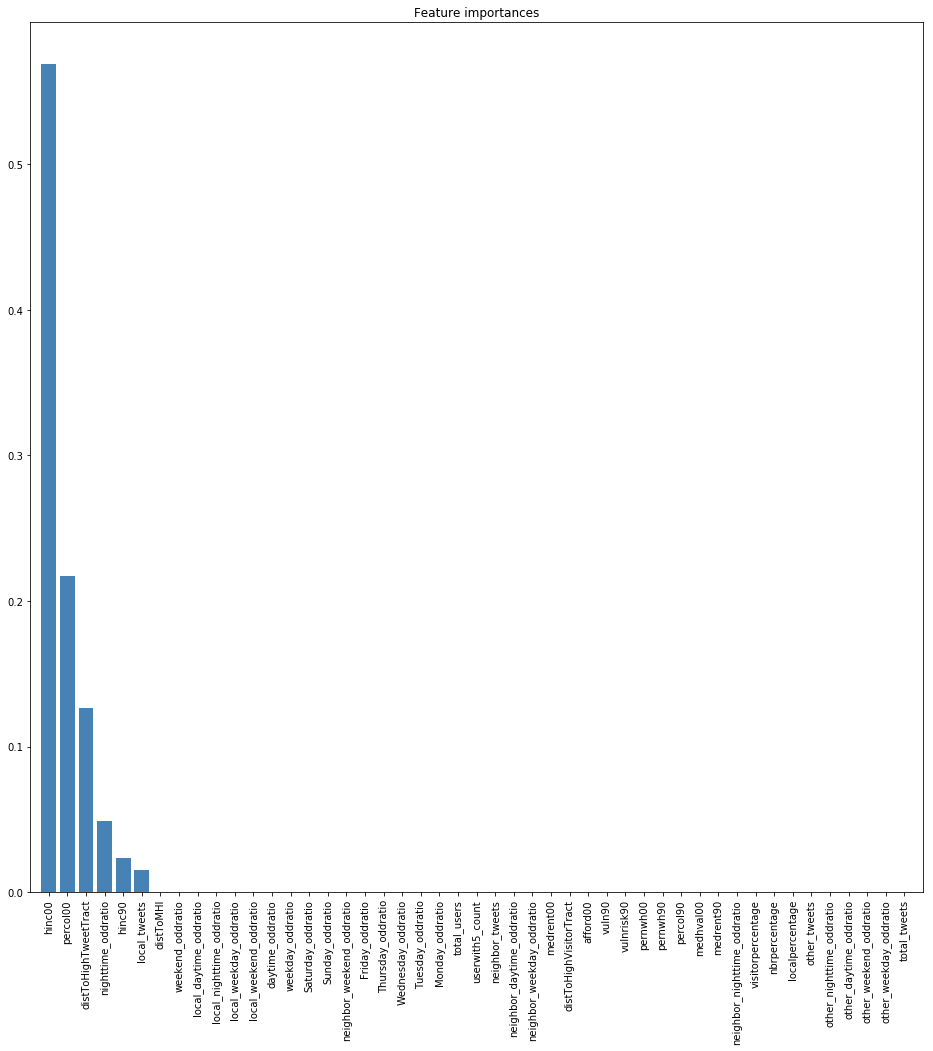

In [101]:
featureImportancePlot(clf3, distmodeldata.columns)

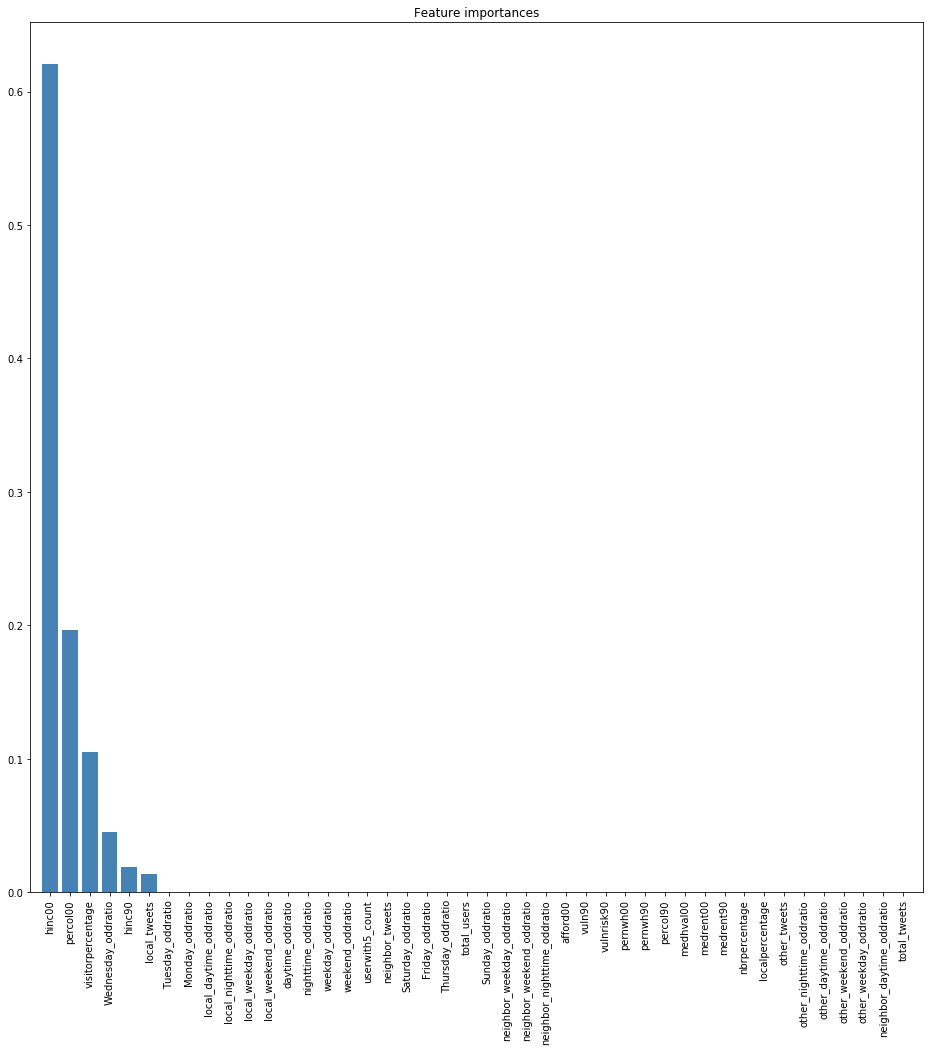

In [102]:
featureImportancePlot(clf2, censusmodeldata.columns)

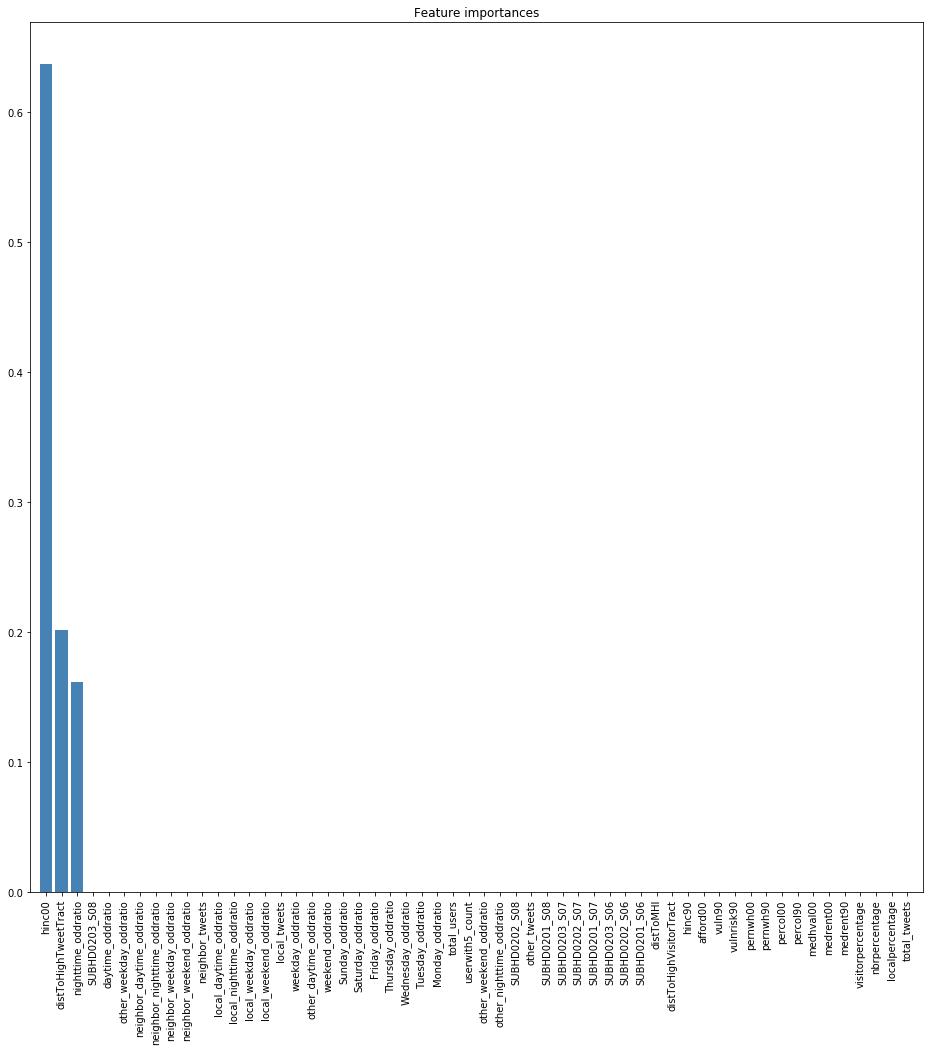

In [103]:
featureImportancePlot(clf4, withnewcenmodel.columns)

In [100]:
#feature importance for logit regression
# def f_importances_pos(coef, names):
#    imp = coef
#    print(imp.shape)
#    imp, names = zip(*sorted(zip(list(imp[0]), names)))
#    imp = imp[:20]
#    names = names[:20]
#    plt.barh(range(len(names)), imp, align='center')
#    plt.yticks(range(len(names)), names)
#    plt.show()